# Data Science Brasil - Desafio Kaggle - Titanic
## Equipe:
* Ricardo Galiardi 
* Wanderson Henrique dos Santos
* Neri Silvestre Filho

In [ ]:
# Caso alguma biblioteca não esteja instalada (descomente a linha)

# Importando xgboost
#!pip install xgboost

# Caso seja necessário atualizar o pacote scikit
#!pip install --force-reinstall scikit-learn==0.20rc1

# Referências

__[score 0.9751](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)__

__[score 0.8134](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)__

__[Boa referência para a separação dos dados e predição](http://aplunket.com/titanic-kaggle-xgboost/)__

In [1]:
# Importando os módulos das bibliotecas de Data Science

import sys
import IPython 
from IPython import display

import numpy as np
import pandas as pd      

import sklearn as sk
import scipy as sp

import matplotlib as plt   
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import Functions as fn
import fn_MLComparison as fnc
import fn_MLAlgorithm as fna

# Faz com que os relatórios (plots) sejam apresentados em uma célula e não em uma nova janela
%matplotlib inline       

-------------------------


In [2]:
# Checando as versões para acompanhamento de atualizações

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(plt.__version__))
print("SciPy version: {}". format(sp.__version__)) 
print("scikit-learn version: {}". format(sk.__version__))
print("IPython version: {}". format(IPython.__version__)) 

Python version: 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
NumPy version: 1.15.4
pandas version: 0.23.4
matplotlib version: 2.2.3
SciPy version: 1.1.0
scikit-learn version: 0.19.2
IPython version: 6.5.0


In [3]:
# Prepara os dados - importando os datasets

dsTrain = pd.read_csv('./Data/train.csv', 
                      names=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

dsTest  = pd.read_csv('./Data/test.csv',  
                      names=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

# Verifica a importação dos dados de treino
print(dsTrain.count())
print('\n')
# Verifica a importação dos dados de teste
print(dsTest.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64


In [4]:
# Cria um dataset com os dois datasets: Treino e de Testes para podermos tratar as variáveis de uma só vez

# Cria novos datasets com a coluna do tipo: treino: 0 e teste: 1
mTrain = dsTrain.copy()
mTest = dsTest.copy()

# Incluíndo as colunas de checagem
mTrain['Train'] = 1
mTrain['FamilySize'] = 1
mTrain['IsAlone'] = 1

mTest['Train'] = 0
mTest['FamilySize'] = 1
mTest['IsAlone'] = 1

In [5]:
# Excluíndo as primeiras colunas que não serão utilizadas pelo modelo e nem usadas pela normalização

drop_column = ['Ticket']
mTrain.drop(drop_column, axis=1, inplace = True)
mTest.drop(drop_column, axis=1, inplace = True)

In [6]:
# Cria uma junção dos dados de treino e teste dados

dsCombined = mTrain.append(mTest, ignore_index=True, sort=False)
dsCombined.info()

#dsCombined = [mTest, mTrain]
#dsCombined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Train          1309 non-null int64
FamilySize     1309 non-null int64
IsAlone        1309 non-null int64
dtypes: float64(3), int64(7), object(4)
memory usage: 143.2+ KB


In [7]:
# Limpeza dos dados e tratamento de dados missing
## Pela avaliação teremos que tratar as colunas: Age e Embarked, não iremos tratar Cabin, por não ser relevante
## E criar novos campos de tratamento

#Pclass
dsCombined['Pclass'] = dsCombined['Pclass'].astype(int)

#SibSp and Parch
dsCombined['FamilySize'] = dsCombined ['SibSp'] + dsCombined['Parch'] + 1

#Size
dsCombined.loc[dsCombined['FamilySize'] > 1, 'IsAlone'] = 0

#Embarked
dsCombined['Embarked'] = dsCombined['Embarked'].fillna('Unknown')

#Fare
dsCombined['Fare'].fillna(dsCombined['Fare'].notna().median())

#Age
dsCombined['Age'].fillna(dsCombined['Age'].notna().median())

#Title
fn.setTitle(dsCombined, 'Name', 'Title')

#Cabin
dsCombined['Cabin'] = dsCombined['Cabin'].fillna('Unknown')
dsCombined['Cabin'] = dsCombined['Cabin'].str[0]

In [8]:
# Separação dos dados para normalização

## Importar a biblioteca de encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label = LabelEncoder()

dsCombined['Sex_Code'] = label.fit_transform(dsCombined['Sex'])
dsCombined['Age_Code'] = label.fit_transform(dsCombined['Age'])
dsCombined['Fare_Code'] = label.fit_transform(dsCombined['Fare'])
dsCombined['Cabin_Code'] = label.fit_transform(dsCombined['Cabin'])
dsCombined['Embarked_Code'] = label.fit_transform(dsCombined['Embarked'])
dsCombined['Title_Code'] = label.fit_transform(dsCombined['Title'])

In [9]:
# Analisando os dados

print(dsCombined.info())
dsCombined.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
PassengerId      1309 non-null int64
Survived         891 non-null float64
Pclass           1309 non-null int32
Name             1309 non-null object
Sex              1309 non-null object
Age              1046 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Fare             1308 non-null float64
Cabin            1309 non-null object
Embarked         1309 non-null object
Train            1309 non-null int64
FamilySize       1309 non-null int64
IsAlone          1309 non-null int64
Title            1309 non-null object
Title_Code       1309 non-null int64
Sex_Code         1309 non-null int64
Age_Code         1309 non-null int64
Fare_Code        1309 non-null int64
Cabin_Code       1309 non-null int64
Embarked_Code    1309 non-null int64
dtypes: float64(3), int32(1), int64(12), object(5)
memory usage: 209.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,...,Train,FamilySize,IsAlone,Title,Title_Code,Sex_Code,Age_Code,Fare_Code,Cabin_Code,Embarked_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,U,...,1,2,0,Mr,12,1,32,20,8,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,...,1,2,0,Mrs,13,0,57,237,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,U,...,1,1,1,Miss,9,0,39,50,8,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,...,1,2,0,Mrs,13,0,53,217,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,U,...,1,1,1,Mr,12,1,53,52,8,2


In [10]:
# Terminando o último tratamento do dataset para disponibilização para análise e predição.

# Fazendo uma cópia dos dados para análise
dsAnalize = dsCombined.copy()

# Excluíndo as colunas que não serão utilizadas pelo modelo após a normalização
drop_column = ['Name','Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title']
dsAnalize.drop(drop_column, axis=1, inplace = True)

In [11]:
# Analisando os dados

print(dsAnalize.info())
dsAnalize.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId      1309 non-null int64
Survived         891 non-null float64
Pclass           1309 non-null int32
SibSp            1309 non-null int64
Parch            1309 non-null int64
Train            1309 non-null int64
FamilySize       1309 non-null int64
IsAlone          1309 non-null int64
Title_Code       1309 non-null int64
Sex_Code         1309 non-null int64
Age_Code         1309 non-null int64
Fare_Code        1309 non-null int64
Cabin_Code       1309 non-null int64
Embarked_Code    1309 non-null int64
dtypes: float64(1), int32(1), int64(12)
memory usage: 138.1 KB
None


,PassengerId,Survived,Pclass,SibSp,Parch,Train,FamilySize,IsAlone,Title_Code,Sex_Code,Age_Code,Fare_Code,Cabin_Code,Embarked_Code
0,1,0.0,3,1,0,1,2,0,12,1,32,20,8,2
1,2,1.0,1,1,0,1,2,0,13,0,57,237,2,0
2,3,1.0,3,0,0,1,1,1,9,0,39,50,8,2
3,4,1.0,1,1,0,1,2,0,13,0,53,217,2,2
4,5,0.0,3,0,0,1,1,1,12,1,53,52,8,2


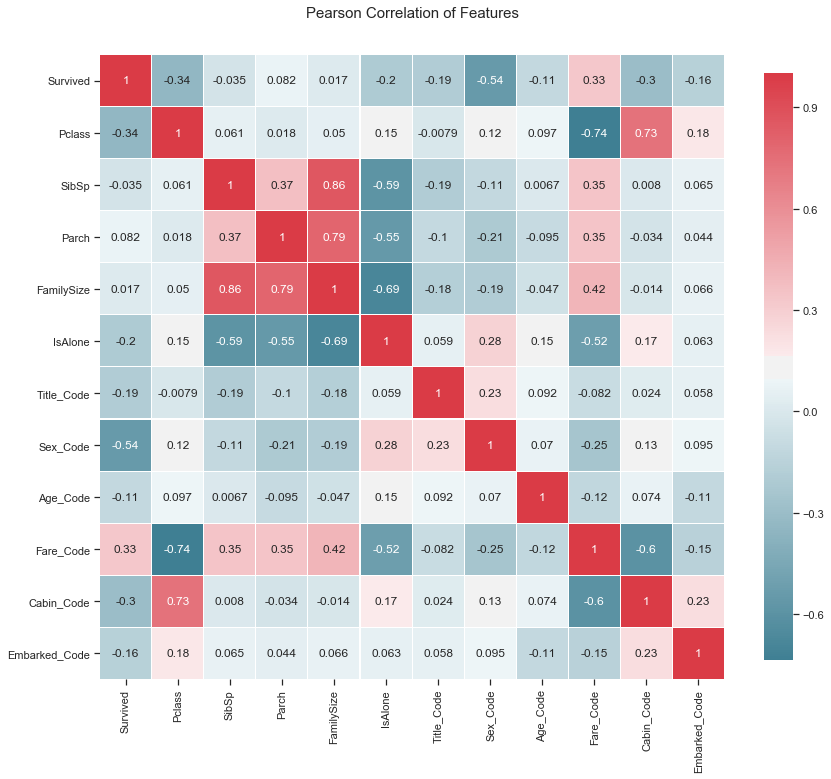

In [12]:
# Análise de Correlação de Pearson das variáveis

columns = ['Survived', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'Title_Code', 'Sex_Code', 'Age_Code', 'Fare_Code', 'Cabin_Code', 'Embarked_Code']
fn.correlation_heatmap(dsAnalize[columns])

In [13]:
# Definição das classes de variáveis aplicaveis aos modelos

# X_train - define os dados independentes de treino
X_train = dsAnalize[dsAnalize['Train'] == 1].drop(['Survived', 'PassengerId', 'Train'], axis=1)

# y_train - define a variável preditora
y_train = dsAnalize[dsAnalize['Train'] == 1]['Survived']

# X_test - define os dados independentes de teste
X_test = dsAnalize[dsAnalize['Train'] == 0].drop(['Survived', 'PassengerId', 'Train'], axis=1)

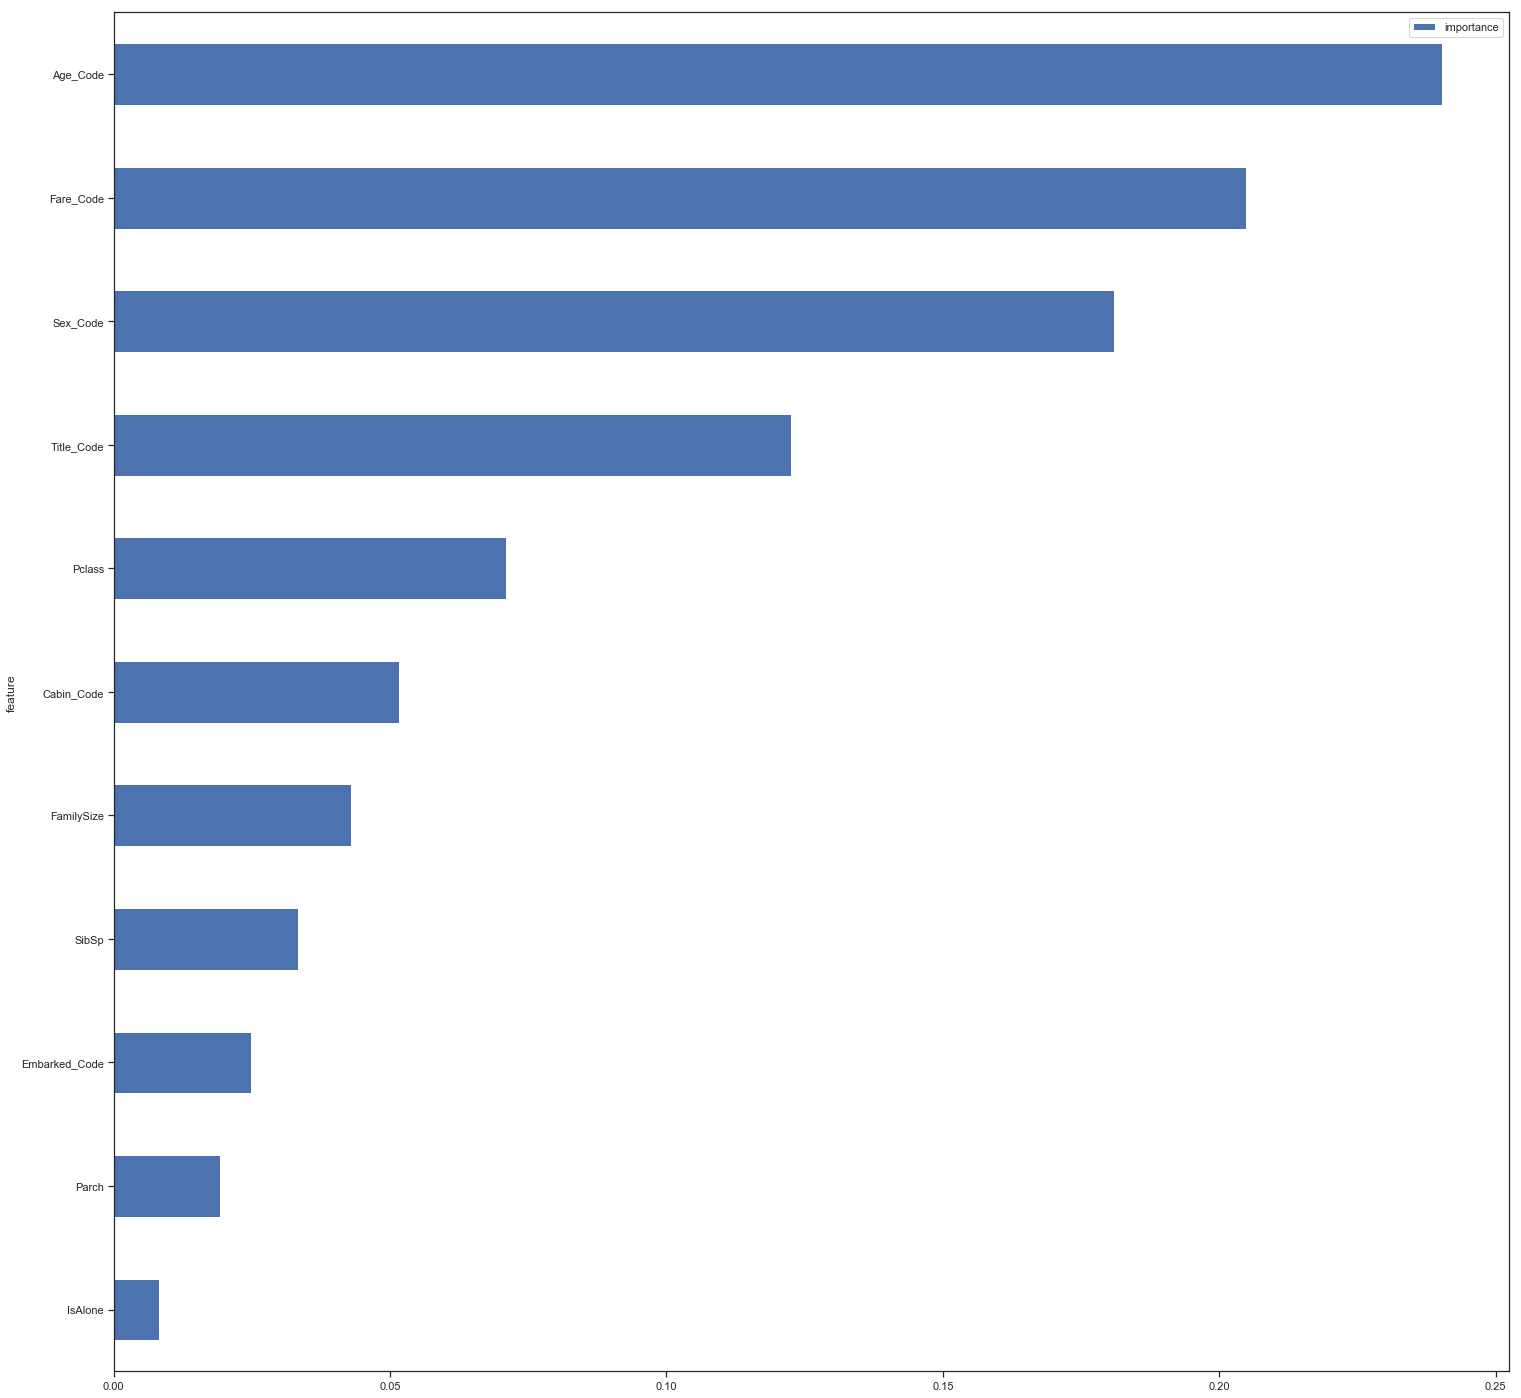

In [14]:
# Verificação das variáveis independentes e sua classificação

from sklearn.model_selection import KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
predictions = clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = predictions.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

## Classificação por Comparação

Series([], Name: (XGBClassifier, 0.9844444444444445), dtype: float64)


,
Classifier,Accuracy
XGBClassifier,0.984444
BaggingClassifier,0.980000
RandomForestClassifier,0.977778
GradientBoostingClassifier,0.975556
ExtraTreesClassifier,0.967778
AdaBoostClassifier,0.940000
LogisticRegressionCV,0.933333
ExtraTreeClassifier,0.932222
LinearDiscriminantAnalysis,0.932222


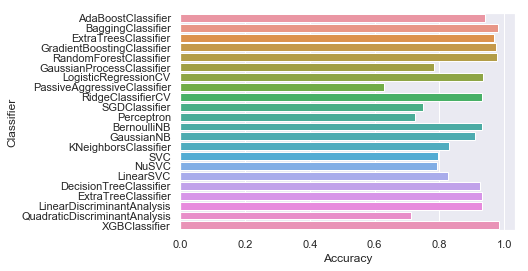

In [15]:
# Classifier(splits, target, features)

#classifiers = fnc.Classifier(12, y_train, X_train)
classifiers = fnc.Classifier(12, y_train, X_train)
print(classifiers.iloc[0])
classifiers

In [16]:
classifier = fnc.Prediction(XGBClassifier(), y_train, X_train, X_test)

## output(output, test, name)
result = fn.output(classifier, mTest, 'mlc')
result

'ok - arquivo gerado: ./Predictions/mlc.csv'

In [37]:
np.trace(classifier)

ValueError: diag requires an array of at least two dimensions

In [34]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [35]:
plot_confusion_matrix(classifier, 
                      normalize    = False,
                      target_names = ['survived', 'die'],
                      title        = "Confusion Matrix")

ValueError: diag requires an array of at least two dimensions

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

predictions = classifier.predict(X_test)
cm = confusion_matrix(X_test, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

## Classificação por Algoritimo (MLA)

In [ ]:
# Classifier(splits, predict, target, features)
classifiers = fna.Classifier(10, 'Survived', y_train, X_train)
print(classifiers.iloc[0])
classifiers

In [ ]:
classifier = fnc.Prediction(XGBClassifier(), y_train, X_train, X_test)

## output(output, test, name)
result = fn.output(classifier, mTest, 'mla')
result

In [ ]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(XGBClassifier(), X_train, y_train, cv=10)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

In [ ]:
# Histograma residual

sns.distplot((y_test-predictions), bins=50)

## Métricas de avaliação de regressão


Aqui estão três métricas de avaliação comuns para problemas de regressão:

**Mean absolute error ** (erro absoluto médio) (MAE) é a média do valor absoluto dos erros:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

** Mean Squared Error ** (erro médio quadrático) (MSE) é a média dos erros quadrados:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

** Root Mean Square Error ** (raiz do erro quadrático médio) (RMSE) é a raiz quadrada da média dos erros quadrados:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparando estas métricas:

- **MAE** é o mais fácil de entender, porque é o erro médio.
- **MSE** é mais popular que o MAE, porque a MSE "puniria" erros maiores, o que tende a ser útil no mundo real.
- **RMSE** é ainda mais popular do que MSE, porque o RMSE é interpretável nas unidades "y".

Todas estas são ** funções de perda **, porque queremos minimizá-las.

In [ ]:
# Avaliando a métrica de avaliação da Regressão

# Importando a biblioteca que faz a Métrica
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
# Importação dos classificadores

# Suprime erros
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier

In [ ]:
# Cria a Comparação dos classificadores

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100, oob_score = True),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    LinearRegression(),
    XGBClassifier()]

splits = 2
cols = ["Classifier", "Accuracy"]
acc_dict = {}
log = pd.DataFrame(columns=cols)
count = 0

#shuff = KFold(n_splits=splits, random_state=42, shuffle=True)
#shuff = ShuffleSplit(n_splits=splits, test_size=0.3, random_state=0)
#shuff = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)

#for train_index, test_index in shuff.split(X, y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count += 1
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=cols)
    log = log.append(log_entry)
    
acc_dict

In [ ]:
# Verifica a acurácia por tipo de classificação

sns.set(style="darkgrid")
sns.barplot(x='Accuracy', y='Classifier', data=log)

log.groupby(['Classifier', 'Accuracy']).count().sort_values(by=['Accuracy'], ascending=False)

In [27]:
# Com base no melhor classificador, é gerada a Predicção.

classifier = XGBClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [28]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
#predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [891, 418]

In [ ]:
# Cria o Dataframe com os dados para envio ao Kaggle

dssubmission = pd.DataFrame({'PassengerId': ds['PassengerId'], 'Survived': predictions})

In [ ]:
# Converte o DataFrame para um arquivo csv para envio ao Kaggle
filename = 'kaggle_titanic.csv'

dssubmission.to_csv(filename, index=False)